# Wildfire

In [66]:
import os, sys
import rasterio
from rasterio import features
from osgeo import gdal
from matplotlib import pyplot
import numpy as np
from osgeo import ogr
import fiona
import geopandas
import shapely
import scipy

In [67]:
work_dir = "./data/"
image = os.path.join(work_dir, "LWIR_QuickMosaic_16-bit_9327.tiff")

In [68]:
dataset = rasterio.open(image)

## Printing image metadata

In [69]:
print(f'Name of image: {dataset.name}')
print(f'Mode of image: {dataset.mode}')
print(f'Width of image: {dataset.width}')
print(f'Height of image: {dataset.height}')
print(f'Bounding Box of image: {dataset.bounds}')
print(f'CRS of image: {dataset.crs}')
print(f'Indexes of image: {dataset.indexes}')
print(f'DType of image: {dataset.dtypes[0]}')

Name of image: ./data/LWIR_QuickMosaic_16-bit_9327.tiff
Mode of image: r
Width of image: 5184
Height of image: 12800
Bounding Box of image: BoundingBox(left=-122.446287, bottom=41.39167100000001, right=-122.35966, top=41.553101000000005)
CRS of image: EPSG:4326
Indexes of image: (1,)
DType of image: uint16


In [70]:
band1 = dataset.read(1)
band1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

## Visualizing image

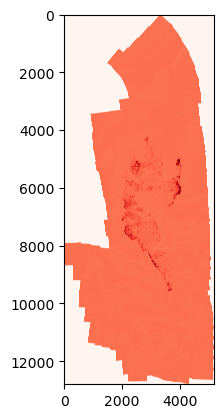

In [71]:
pyplot.imshow(band1, cmap='Reds')
pyplot.show()

## Classification

In [72]:
print(f'Band1 mean: {np.mean(band1)}')
print(f'Band1 max: {np.amax(band1)}')

Band1 mean: 21062.48074881848
Band1 max: 65535


In [73]:
np.median(band1)

31233.0

In [74]:
np.std(band1.nonzero())

3184.3857223289774

In [75]:
fire_treshold = 33332

In [76]:
raster_classify = np.where(band1 > fire_treshold, 1, 0)

## Saving new raster

In [77]:
with rasterio.open(
    './data/LWIR_QuickMosaic_9327_classified.tif',
    'w',
    driver='GTiff',
    height=dataset.height,
    width=dataset.width,
    count=1,
    dtype='uint8',
    crs=dataset.crs,
) as dst:
    dst.write(raster_classify, 1)

c:\Users\arno\anaconda3\envs\wildfire\lib\site-packages\rasterio\__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [78]:
dst.close()

In [79]:
image_clas = rasterio.open('./data/LWIR_QuickMosaic_9327_classified.tif', mode='r')

c:\Users\arno\anaconda3\envs\wildfire\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [80]:
band_clas = image_clas.read(1)

## Exporting raster to polygon

https://rasterio.readthedocs.io/en/latest/cli.html#shapes

https://snyk.io/advisor/python/rasterio/functions/rasterio.features.shapes

https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html

In [81]:
#os.system('rio shapes data/LWIR_QuickMosaic_9327_classified.tif --bidx 1 --precision 1 --collection > data/raster_clas.geojson')

In [82]:
with rasterio.open(image) as src:
    # Read the raster data and metadata
    raster_data = src.read(1)  # Read the first band of the raster
    raster_meta = src.meta

    # Classify the raster data
    classified_data = np.where(raster_data < 35000, 0, 1)

# Update the metadata with the new data type and nodata value
raster_meta.update(dtype=rasterio.int8, nodata=None)

# Write the classified raster to a new file
with rasterio.open('./data/RasterClass.tif', 'w', **raster_meta) as dst:
    dst.write(classified_data, 1)

# Convert the classified raster to polygons
shapes = features.shapes(classified_data, transform=raster_meta['transform'])

In [83]:
# Write the polygons to a shapefile
with fiona.open('./data/HeatPoly.shp', 'w', 'ESRI Shapefile', crs=fiona.crs.from_epsg(4326), schema={'geometry': 'Polygon', 'properties': {}}) as shapefile:
    for shape in shapes:
        value = shape[1]
        if value > 0:
            feature = {'geometry': shape[0], 'properties': {}}
            shapefile.write(feature)


## Change projection
https://epsg.io/26910

In [84]:
shape = geopandas.read_file('./data/HeatPoly.shp')
shape_utm = shape.to_crs("EPSG:26910")
shape_utm.to_file('./data/HeatPoly_epsg26910.shp')

## Aggregate Polygons

https://shapely.readthedocs.io/en/stable/reference/shapely.concave_hull.html?highlight=concav#shapely.concave_hull

In [85]:
dissolve = shapely.unary_union(shape_utm.geometry)
concave = shapely.concave_hull(dissolve, ratio=0.1, allow_holes=False)

In [86]:
gdf = geopandas.GeoDataFrame(index=[0], crs='EPSG:26910', geometry=[concave])
gdf.to_file('./data/HeatPoly_01.shp', crs="EPSG:26910")

<Axes: >

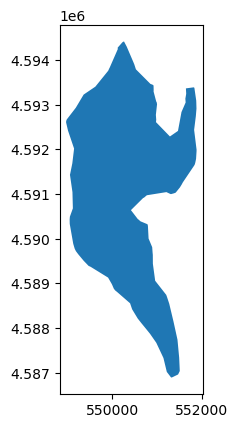

In [88]:
gdf.plot()

In [29]:
from rasterio.plot import show_hist

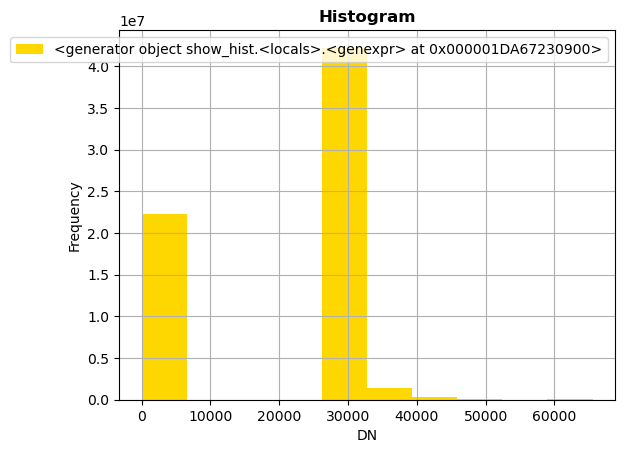

In [32]:
show_hist(band1)

In [51]:
from scipy.signal import argrelextrema, find_peaks, argrelmax

In [38]:
print(np.bincount(band1.flatten()))

[22327485        0        0 ...        1        0     1105]


In [50]:
peaks, _ = find_peaks(band1.flatten(), height=10)
print(len(peaks))

7324543


In [20]:
test = argrelextrema(band1.flatten(), np.greater)
print(test)

(array([   13697,    18881,    24067, ..., 66349161, 66354331, 66354345],
      dtype=int64),)


In [34]:
test2 = argrelmax(band1.flatten())
print(test2)

(array([   13697,    18881,    24067, ..., 66349161, 66354331, 66354345],
      dtype=int64),)
